In [1]:
import torch as t
import matplotlib.pyplot as plt
import numpy as np

In [2]:
phi_ext = t.tensor(0.995*t.pi).cdouble()
EJ = 10*2*t.pi
EC = EJ/100
# E_CJ = 1/100

T = 30
q_max = 8
NHilbert = q_max*2 + 1

Id = t.eye(NHilbert).cdouble()
q = t.arange(-q_max,q_max+1,1)
q_mat = t.diag(q).cdouble()

cos_mat = 0.5*(t.diag(t.ones(NHilbert-1),-1) + t.diag(t.ones(NHilbert-1),1)).cdouble()
# cos2_mat = 0.5*(t.diag(t.ones(NHilbert-2).cdouble(),-2)*t.exp(-1j*phi_ext) \
#                             + t.diag(t.ones(NHilbert-2),2)*t.exp(1j*phi_ext))

KinE = 4*EC*(t.kron(q_mat**2,Id) + t.kron(Id,q_mat**2))
# V_mat = EJ*t.kron(q_mat,Id)
V_mat = t.kron(q_mat,Id)
cos_mat = t.kron(cos_mat,Id) + t.kron(Id,cos_mat)

upper = t.diag(t.ones(NHilbert-1).cfloat(),1)
lower = t.diag(t.ones(NHilbert-1).cfloat(),-1)
cos2_mat = 0.5*(t.exp(1j*phi_ext)*t.kron(lower,upper) + t.exp(-1j*phi_ext)*t.kron(upper,lower))

In [3]:
1 - 0.022 + 0.1*(-0.0027936870890755317)

0.9777206312910924

In [4]:
lr = 0.1
envelope_amp = 1.3314045280692275
detuning = 1 - 0.022 + lr*(-0.0027936870890755317)
# omega_d = 4.5
# phase =	1.7529

decline_end = 10.0
ascend_start = 20.0
level = 0.7

eigvals, eigvecs = np.linalg.eigh(np.asarray(KinE - EJ*(cos_mat + level*cos2_mat)))
omega_d = eigvals[1] - eigvals[0]
omega_d

2.4825403959499113

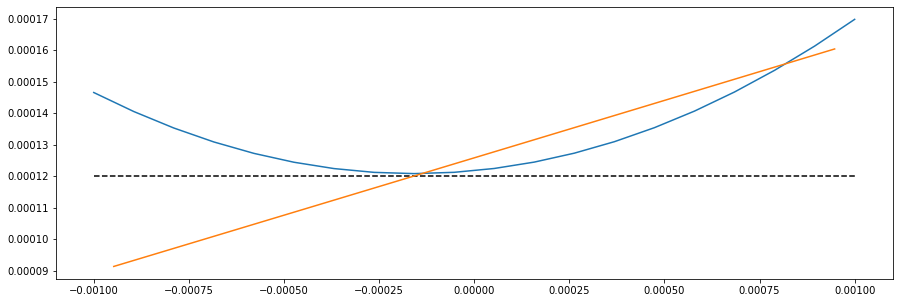

In [27]:
import numpy as np
import matplotlib.pyplot as plt
tmp = np.array([0.00014653016687293796,
 0.0001404915464853218,
 0.00013525825062232766,
 0.00013083053415630097,
 0.00012720865247917157,
 0.00012439286029142238,
 0.00012238341231807226,
 0.00012118056273657807,
 0.00012078456554309724,
 0.00012119567436608136,
 0.0001224141424636116,
 0.00012444022296742574,
 0.00012727416841884498,
 0.00013091623117611473,
 0.00013536666327929048,
 0.0001406257163227842,
 0.0001466936415990272,
 0.00015357069009469537,
 0.0001612571123215112,
 0.00016975315851408546])
tmpx = np.linspace(-0.001,0.001,20)
plt.figure(figsize=(15,5))
plt.plot(tmpx,tmp)
plt.plot(0.5*(tmpx[1:] + tmpx[:-1]), 0.0005*(tmp[1:] - tmp[:-1])/(tmpx[1:] - tmpx[:-1])+0.00012)
plt.hlines(0.00012,-0.001,0.001,color='k',linestyle='--')

(array([-0.02675003,  0.01157545,  0.049961  ]),
 array([-0.00052632,  0.        ,  0.00052632]))

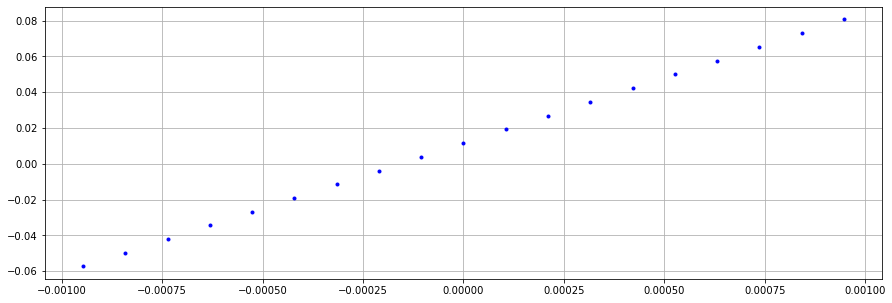

In [51]:
plt.figure(figsize=(15,5))
plt.plot(0.5*(tmpx[1:] + tmpx[:-1]),(tmp[1:] - tmp[:-1])/(tmpx[1:] - tmpx[:-1]),'b.')
plt.grid()
((tmp[1:] - tmp[:-1])/(tmpx[1:] - tmpx[:-1]))[[4,9,14]], 0.5*(tmpx[1:] + tmpx[:-1])[[4,9,14]]

In [5]:
# H = KinE - EJ*(cos_mat + alpha*cos2_mat)
H0 = KinE - EJ*cos_mat
H0 = np.asarray(H0)
V_mat = np.asarray(V_mat)
cos2_mat = np.asarray(cos2_mat)

In [6]:
from numba import jit, vectorize
# @jit
@vectorize()
def get_control(times: np.ndarray, 
                detuning: float = detuning, 
                omega_d: float = omega_d,
                envelope_amp: float = envelope_amp, 
                decline_end: float = decline_end, 
                ascend_start: float = ascend_start) -> float:
    
    if times <= decline_end or times >= ascend_start:
        return 0
    pulse = np.cos(detuning*omega_d*(times-decline_end))
    if times < decline_end + 2:
        return envelope_amp*pulse*np.sin(0.25*np.pi*(times-decline_end))**2
    elif times > ascend_start - 2:
        return envelope_amp*pulse*np.sin(0.25*np.pi*(times-ascend_start-4))**2
    return envelope_amp*pulse

@jit
def vget_control(times):
    return get_control(times,detuning,omega_d,envelope_amp,decline_end,ascend_start)

# @jit
@vectorize()
def get_alpha(times: float,
              level: float = level, 
              decline_end: float = decline_end, 
              ascend_start: float = ascend_start) -> float:
    if times < decline_end:
        return 1 - (1-level)/decline_end*times
    elif times > ascend_start:
        return level + (1 - level)/decline_end*(times-ascend_start)
    return level

@jit
def vget_alpha(times):
    return get_alpha(times,level,decline_end,ascend_start)

@jit
# @vectorize
def get_H(times: float,
          H0: np.ndarray = H0,
          cos2_mat: np.ndarray = cos2_mat,
          V_mat: np.ndarray = V_mat) -> np.ndarray:
    
    H = H0 - EJ*get_alpha(times)*cos2_mat
    V = get_control(times)*V_mat
    return H + V

@jit
def vget_H(times: float,
        H0: np.ndarray = H0,
        cos2_mat: np.ndarray = cos2_mat,
        V_mat: np.ndarray = V_mat) -> np.ndarray:

    H = H0 - EJ*vget_alpha(times).reshape(-1,1,1)*cos2_mat
    V = vget_control(times).reshape(-1,1,1)*V_mat
    return H + V

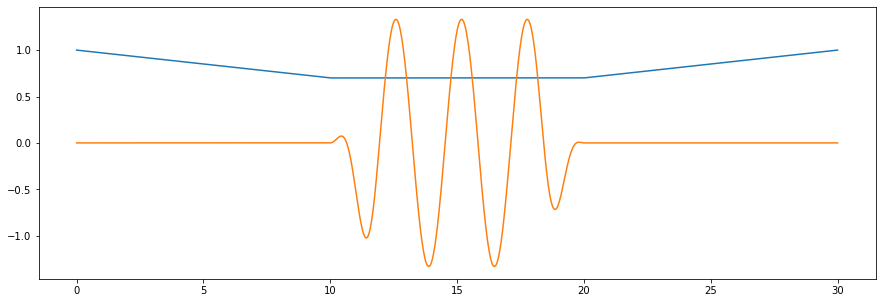

In [7]:
# for i in 
plt.figure(figsize=(15,5))
# plt.plot(np.linspace(0,30,1000),[get_control(times) for times in np.linspace(0,30,1000)])
# plt.plot(np.linspace(0,30,1000),[get_control(times,omega_d=0) for times in np.linspace(0,30,1000)])
# plt.grid()
# # plt.ylim(-2,2)
# plt.plot(np.linspace(0,30,1000),[get_alpha(times) for times in np.linspace(0,30,1000)])
ts = np.linspace(0,30,1000)
plt.plot(ts,vget_alpha(ts))
plt.plot(ts,vget_control(ts))

In [8]:
_, tmp_eigvecs = np.linalg.eigh(np.asarray(KinE - EJ*(cos_mat + cos2_mat)))
# omega_d = eigvals[1] - eigvals[0]
y0 = tmp_eigvecs[:,0]

In [9]:
# eigvals, eigvecs = np.linalg.eigh(H)
# y0 = eigvecs[:,0]

# y0 = np.zeros(NHilbert**2,dtype=np.complex128)
# y0[0] = 1

# V2_mat = eigvecs.T.conj()@V_mat@eigvecs

@jit
# @vectorize()
def _H(times: float) -> np.ndarray: #,       V_mat: np.ndarray = V2_mat
    H = get_H(times)
    # G = np.diag(np.exp(1j*eigvals*times))
    # H = G@V_mat@G.conj()*get_control(times)
    return H

@jit
def func(times: float,
         y: np.ndarray) -> np.ndarray:
    # y = np.ascontiguousarray(y)
    times = np.asarray(times).reshape(-1)
    # print(times.shape)
    H = vget_H(times)
    out = np.dot(H,y)*(-1j)
    return out

@jit
def jac(times: float,
        y: np.ndarray) -> np.ndarray:
    times = np.asarray(times).reshape(-1)
    H = vget_H(times)
    return H.squeeze()*(-1j)

In [347]:
np.dot(vget_H(np.array([0,10])),y0.reshape(-1,1)).shape

(2, 289, 1)

In [381]:
# vget_control(np.asarray(10).reshape(-1))

array([0.])

In [397]:
# func(np.array([0,10]),y0)
# _H(np.array([0.,10.]))

In [19]:
from scipy.integrate import solve_ivp

out = solve_ivp(func,
                y0=y0_pulse,
                rtol=1e-10,
                atol=1e-12,
                t_span=[10,12],
                t_eval=np.linspace(10,12,100),
                vectorized=True,
                method='BDF',
                jac=jac)

In [281]:
vget_control = np.vectorize(get_control)
vget_alpha = np.vectorize(get_alpha)
@jit
def vget_H(times: np.ndarray,
          H0: np.ndarray = H0,
          cos2_mat: np.ndarray = cos2_mat,
          V_mat: np.ndarray = V_mat) -> np.ndarray:
    
    H = H0 - EJ*vget_alpha(times).reshape(-1,1,1)*cos2_mat
    V = vget_control(times).reshape(-1,1,1)*V_mat
    return H + V
vget_H(np.array([10,15])).shape

C:\Users\jv97\AppData\Local\Temp/ipykernel_6244/2507534182.py:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "vget_H" failed type inference due to: Untyped global name 'vget_alpha': Cannot determine Numba type of <class 'numpy.vectorize'>

File "..\..\..\..\AppData\Local\Temp\ipykernel_6244\2507534182.py", line 9:
<source missing, REPL/exec in use?>

  @jit
c:\Users\jv97\anaconda3\envs\myenv\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "vget_H" was compiled in object mode without forceobj=True.

File "..\..\..\..\AppData\Local\Temp\ipykernel_6244\2507534182.py", line 3:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
c:\Users\jv97\anaconda3\envs\myenv\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

Fo

(2, 289, 289)

In [10]:
# dec_out = solve_ivp(func,
#                     y0=y0,
#                     rtol=1e-10,
#                     atol=1e-12,
#                     t_span=[0,10],
#                     t_eval=[0,10],
#                     vectorized=False,
#                     method='BDF',
#                     jac=jac)
y0_pulse = np.load("y0_pulse.npy")

In [250]:
# @jit
# def Ufunc(times: float,
#           y: np.ndarray) -> np.ndarray:
#     U = y.reshape(289,289)
#     H = _H(times)
#     out = np.dot(H,U).flatten()*(-1j)
#     return out

# @jit
# def Ujac(times: float,
#         y: np.ndarray) -> np.ndarray:
#      H = _H(times)
#      return H*(-1j)

# y0_U = np.eye(NHilbert**2,dtype=np.complex128).flatten()

# asc_out = solve_ivp(Ufunc,
#                     y0=y0_U,
#                     rtol=1e-10,
#                     atol=1e-12,
#                     t_span=[20,30],
#                     t_eval=[20,30],
#                     vectorized=False,
#                     method='BDF')
from tqdm import tqdm
from scipy.linalg import expm

U = np.eye(NHilbert**2,dtype=np.complex128)
times = np.linspace(20,30,6001)
dt = np.mean(times[1:] - times[:-1])
for time in tqdm(times):
    U = np.dot(expm(-1j*get_H(time)*dt),U)


100%|██████████| 6001/6001 [05:48<00:00, 17.21it/s]


In [253]:
np.trace(U.T.conj()@U)/289, np.square(np.abs(tmp_eigvecs.T.conj()@U@pulse_out2.y[:,-1])).sum()

((1.0000000000003961+0j), 0.9999922781474283)

In [75]:
# np.save("AscendEvolutionOperator.npy",U)
# np.load("AscendEvolutionOperator.npy")

In [259]:
dt

0.0016666666666666668

In [258]:
np.square(np.abs(tmp_eigvecs[:,0].conj()@U@pulse_out2.y[:,-1]))#, np.square(np.abs(tmp_eigvecs[:,0].conj()@U@pulse_out.y[:,-1]))

1.795546840628487e-05

In [87]:
pulse_out = solve_ivp(func,
                      y0=y0_pulse,
                      rtol=1e-10,
                        atol=1e-12,
                        t_span=[10,20],
                        t_eval=np.linspace(10,20,500),
                        vectorized=False,
                        method='BDF',
                        jac=jac)

In [20]:
pulse_out5 = solve_ivp(func,
                      y0=y0,
                      rtol=1e-10,
                        atol=1e-12,
                        t_span=[0,30],
                        t_eval=np.linspace(0,30,1000),
                        vectorized=True,
                        method='BDF',
                        jac=jac)

C:\Users\jv97\AppData\Local\Temp/ipykernel_10552/2124978149.py:17: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "func" failed type inference due to: No implementation of function Function(<function dot at 0x000002A22F4B8EE0>) found for signature:
 
 >>> dot(array(complex128, 3d, C), array(complex128, 2d, A))
 
There are 4 candidate implementations:
      - Of which 4 did not match due to:
      Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba\core\overload_glue.py: Line 131.
        With argument(s): '(array(complex128, 3d, C), array(complex128, 2d, A))':
       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       No implementation of function Function(<intrinsic stub>) found for signature:
        
        >>> stub(array(complex128, 3d, C), array(complex128, 2d, A))
        
       There are 2 candidate imple

In [106]:
# occs2 = np.square(np.abs(eigvecs.T.conj()@pulse_out2.y))
occs = np.square(np.abs(eigvecs.T.conj()@pulse_out.y[:,(pulse_out.t>10)&(pulse_out.t<20)]))

In [107]:
pulse_out

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 195260
     njev: 1
      nlu: 14147
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.03003003,  0.06006006,  0.09009009,  0.12012012,
        0.15015015,  0.18018018,  0.21021021,  0.24024024,  0.27027027,
        0.3003003 ,  0.33033033,  0.36036036,  0.39039039,  0.42042042,
        0.45045045,  0.48048048,  0.51051051,  0.54054054,  0.57057057,
        0.6006006 ,  0.63063063,  0.66066066,  0.69069069,  0.72072072,
        0.75075075,  0.78078078,  0.81081081,  0.84084084,  0.87087087,
        0.9009009 ,  0.93093093,  0.96096096,  0.99099099,  1.02102102,
        1.05105105,  1.08108108,  1.11111111,  1.14114114,  1.17117117,
        1.2012012 ,  1.23123123,  1.26126126,  1.29129129,  1.32132132,
        1.35135135,  1.38138138,  1.41141141,  1.44144144,  1.47147147,
        1.5015015 ,  1.53153153,  1.56156156,  1.59159159,  1.62162162,
        1.65165165,  1

In [23]:
pulse_out

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 567000
     njev: 1
      nlu: 33032
      sol: None
   status: 0
  success: True
        t: array([10.        , 10.02004008, 10.04008016, 10.06012024, 10.08016032,
       10.1002004 , 10.12024048, 10.14028056, 10.16032064, 10.18036072,
       10.2004008 , 10.22044088, 10.24048096, 10.26052104, 10.28056112,
       10.3006012 , 10.32064128, 10.34068136, 10.36072144, 10.38076152,
       10.4008016 , 10.42084168, 10.44088176, 10.46092184, 10.48096192,
       10.501002  , 10.52104208, 10.54108216, 10.56112224, 10.58116232,
       10.6012024 , 10.62124248, 10.64128257, 10.66132265, 10.68136273,
       10.70140281, 10.72144289, 10.74148297, 10.76152305, 10.78156313,
       10.80160321, 10.82164329, 10.84168337, 10.86172345, 10.88176353,
       10.90180361, 10.92184369, 10.94188377, 10.96192385, 10.98196393,
       11.00200401, 11.02204409, 11.04208417, 11.06212425, 11.08216433,
       11.10220441, 11

In [116]:
occs = np.zeros((pulse_out.t.shape[0],3))
for i, time in tqdm(enumerate(pulse_out.t)):
    _, inst_eigvecs = np.linalg.eigh(H0 - EJ*get_alpha(time)*cos2_mat)
    occs[i,:-1] = np.square(np.abs(inst_eigvecs[:,[0,1]].T.conj()@pulse_out.y[:,i]))

1000it [00:15, 62.94it/s]


In [238]:
occs5 = np.zeros((pulse_out5.t.shape[0],3))
for i, time in tqdm(enumerate(pulse_out5.t)):
    _, inst_eigvecs = np.linalg.eigh(H0 - EJ*get_alpha(time)*cos2_mat)
    occs5[i,:-1] = np.square(np.abs(inst_eigvecs[:,[0,1]].T.conj()@pulse_out5.y[:,i]))
occs5[:,-1] = 1-occs5[:,[0,1]].sum(1)

1000it [00:20, 48.00it/s]


In [126]:
occs[:,-1] = 1-occs[:,[0,1]].sum(1)

In [150]:
pulse_out.t[333*2]

20.0

In [151]:
np.square(np.abs(pulse_out.y[:,333].conj()@y0_pulse)), np.square(np.abs(pulse_out.y[:,-1].conj()@U@pulse_out2.y[:,-1])), np.square(np.abs(pulse_out.y[:,333*2].conj()@pulse_out2.y[:,-1]))
# pulse_out.t[333]

(0.9999924508388154, 0.9991265900405365, 0.9999855781472186)

In [195]:
pulse_out3.y

array([[ 7.45843889e-10+0.00000000e+00j, -5.27604773e-10+5.26980756e-10j,
         4.26677117e-12-7.45426374e-10j, ...,
        -7.96436230e-10+5.84455588e-11j,  4.68421675e-10-6.16068222e-10j,
         1.91169703e-10+7.60028145e-10j],
       [ 4.75017370e-09-2.41098688e-09j, -1.65718031e-09+5.06165106e-09j,
        -2.38984223e-09-4.75328906e-09j, ...,
        -5.29108505e-09-2.10613825e-09j,  4.97011065e-09-2.58303135e-09j,
        -1.16903204e-09+5.27824973e-09j],
       [ 1.72784747e-08-2.53319793e-08j,  5.67153663e-09+3.01261195e-08j,
        -2.52478361e-08-1.73367959e-08j, ...,
        -2.16938501e-08-2.46683824e-08j,  3.20597326e-08-3.42704357e-10j,
        -1.98593781e-08+2.30718986e-08j],
       ...,
       [ 1.72784749e-08+2.53319793e-08j, -3.01352017e-08-5.71258818e-09j,
         2.53872623e-08-1.72457831e-08j, ...,
        -1.48678472e-08+2.69921245e-08j, -9.65673962e-09-2.91143404e-08j,
         2.85004616e-08+1.26766354e-08j],
       [ 4.75017366e-09+2.41098688e-09j, -5.

In [239]:
occs3[-1], occs[-1], occs4[-1], occs5[-1]

(array([1.85418745e-05, 9.99868186e-01, 1.13272147e-04]),
 array([1.83573776e-05, 9.99868458e-01, 1.13184785e-04]),
 array([1.96375118e-05, 9.99868046e-01, 1.12316551e-04]),
 array([2.27578468e-05, 9.99863187e-01, 1.14055403e-04]))

In [155]:
occs[-1], np.square(np.abs(inst_eigvecs[:,0].conj()@U@pulse_out.y[:,333*2]))

(array([1.83573776e-05, 9.99868458e-01, 1.13184785e-04]), 0.00071233882152688)

(1e-05, 2)

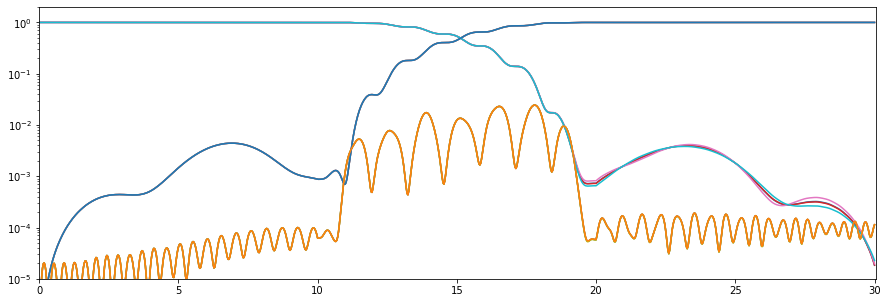

In [245]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(pulse_out2.t,occs2[:2].T);
# ax.plot(pulse_out2.t,1 - occs2[:2].sum(0));
ax.plot(pulse_out.t,occs[:,0]);
ax.plot(pulse_out.t,occs[:,1])
ax.plot(pulse_out.t,occs[:,-1]);

ax.plot(pulse_out3.t,occs3[:,0]);
ax.plot(pulse_out3.t,occs3[:,1])
ax.plot(pulse_out3.t,occs3[:,-1]);

ax.plot(pulse_out4.t,occs4[:,0]);
ax.plot(pulse_out4.t,occs4[:,1])
ax.plot(pulse_out4.t,occs4[:,-1]);

ax.plot(pulse_out5.t,occs5[:,0]);
ax.plot(pulse_out5.t,occs5[:,1])
ax.plot(pulse_out5.t,occs5[:,-1]);
# ax.plot(pulse_out.t[(pulse_out.t>10)&(pulse_out.t<20)],occs[:2].T,linestyle='--');
# ax.plot(pulse_out.t[(pulse_out.t>10)&(pulse_out.t<20)],1 - occs[:2].sum(0),linestyle='--');
# ax.plot(np.linspace(10,20,500),[get_control(times) for times in np.linspace(10,20,500)])
# ax.plot(1-occs.sum(0))
ax.set_yscale('log')
ax.set_xlim(-0.01,30.05)
ax.set_ylim(1e-5,2)
# ax.set_xlim(29.99,30.01)
# ax.set_ylim(1.6e-5,2.5e-5)

In [167]:
a = - (pulse_out.y[:,[-1]].T.conj()@tmp_eigvecs[:,[0]]@tmp_eigvecs[:,[0]].T.conj()).squeeze()
a_theta = np.zeros(1)
psi  = pulse_out.y[:,-1]
y0_aug = np.concatenate([a,psi,a_theta],axis=0)

@jit
def dudtheta(times: float,
            theta: np.ndarray, 
            omega_d: float = omega_d,
            detuning: float = detuning,
            decline_end: float = decline_end, 
            ascend_start: float = ascend_start) -> float:

    if times <= decline_end or times >= ascend_start:
        return 0
    pulse = -omega_d*(times-decline_end)*np.sin(detuning*omega_d*(times-decline_end))
    if times < decline_end + 2:
        return envelope_amp*pulse*np.sin(0.25*np.pi*(times-decline_end))**2
    elif times > ascend_start - 2:
        return envelope_amp*pulse*np.sin(0.25*np.pi*(times-ascend_start-4))**2
    return envelope_amp*pulse

@jit
def augmented_dynamics(times: float,
                       y0_aug: np.ndarray) -> np.ndarray:
    # a = y0_aug[:-3]
    # a_theta = y0_aug[-3:]
    N = 289
    out = np.zeros_like(y0_aug)
    H = get_H(times)
    out[:289] = -np.dot(y0_aug[:289],H)*(-1j)
    out[289:-1] = np.dot(H,y0_aug[289:-1])*(-1j)
    out[-1:] = np.dot(y0_aug[:289],np.dot(V_mat,y0_aug[289:-1]).reshape(-1,1)*dudtheta(times,y0_aug[-1:]))*(-1j)
    # out[-1:] = np.dot(y0_aug[:289],np.kron(np.dot(V_mat,y0_aug[289:-1]).reshape(-1,1),dudtheta(times,y0_aug[-1:])))*(-1j)
    return out

In [168]:
adj_out = solve_ivp(augmented_dynamics,
                 t_span=(30,0),
                 rtol=1e-10,
                 atol=1e-12,
                 y0=y0_aug,
                 t_eval=[0],
                 method = 'BDF')

C:\Users\jv97\AppData\Local\Temp/ipykernel_6244/2141416681.py:31: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 1d, A), array(complex128, 2d, C))
  out[:289] = -np.dot(y0_aug[:289],H)*(-1j)
C:\Users\jv97\AppData\Local\Temp/ipykernel_6244/2141416681.py:33: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (readonly array(complex128, 2d, C), array(complex128, 1d, A))
  out[-1:] = np.dot(y0_aug[:289],np.dot(V_mat,y0_aug[289:-1]).reshape(-1,1)*dudtheta(times,y0_aug[-1:]))*(-1j)


In [173]:
# augmented_dynamics(20,y0_aug)
adj_out.y[-1], 1-0.022

(array([-0.00279369+0.02579873j]), 0.978)